In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import sys
sys.path.append('src/')

import csv
from utils import DEFAULT_PALETTE
from WADParser import WAD_file
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import struct
import re
from copy import deepcopy

In [31]:
w = WAD_file('WADs/HEXEN.WAD')

2025-03-01 14:39:40.384 | INFO     | WADParser:__init__:32 - HEXEN IWAD found at WADs/HEXEN.WAD.
2025-03-01 14:39:40.384 | INFO     | WADParser:_get_palette:101 - Palette extracted.
2025-03-01 14:39:40.396 | INFO     | WADParser:_parse_levels:141 - 31 levels found in this WAD.
2025-03-01 14:39:40.396 | INFO     | WADParser:_parse_by_markers:171 - 101 FLATS found in this WAD.
2025-03-01 14:39:40.400 | INFO     | WADParser:_parse_by_markers:171 - 2692 SPRITES found in this WAD.
2025-03-01 14:39:40.584 | INFO     | WADParser:_parse_things:113 - HEXEN THINGS loaded.


In [28]:
vx_offset, vx_size = w.maps['MAP02']['VERTEXES']
w.wad.seek(vx_offset)
lump = w.wad.read(vx_size)

vertices = np.array([struct.unpack('<hh', lump[i:i+4]) for i in range(0, len(lump), 4)])
vertices.shape

(1680, 2)

In [29]:
l_offset, l_size = w.maps['MAP02']['LINEDEFS']
w.wad.seek(l_offset)
lump = w.wad.read(l_size)

linedefs = np.array([struct.unpack('<hhhhhhh', lump[i:i+14]) for i in range(0, len(lump), 14)]).astype(np.int16)

lines = vertices[linedefs[:, 0:2]]
flags = linedefs[:, 2]

for line, flag in zip(lines, flags):
    
    if flag & 0x01:  # Impassable
        plt.plot(line[:, 0], line[:, 1], color='black', linewidth=1)

    if flag & 0x04:  # Two-sided
        plt.plot(line[:, 0], line[:, 1], color='grey', linewidth=1)
    
    if flag & 0x20:  # Secret (not displayed on automap)
        plt.plot(line[:, 0], line[:, 1], color='orange', linewidth=1)

plt.axis('equal')
plt.show()      

error: unpack requires a buffer of 14 bytes

In [130]:
d = {int(k): int(v) for k, v in zip(linedefs[:, 0], linedefs[:, 1])}
lines = []
idx = 0

while True:
    if len(d) == 0: break
    start = next(iter(d))
    line = [start]
    while True:
        next_vertex = d.pop(start, None)
        if next_vertex is None:
            break
        line.append(next_vertex)
        start = next_vertex
    lines.append(line)

In [132]:
d = {int(k): int(v) for k, v in zip(linedefs[:, 0], linedefs[:, 1])}
d2 = d.copy()
lines = []
idx = 0

while True:
    if len(d) == 0: break
    start = next(iter(d))
    line = [start]
    while True:
        next_vertex = d.pop(start, None)
        save_vertex = d2.get(start, None)

        if (next_vertex is None) & (save_vertex is None):
            break
        elif (next_vertex is None) & (save_vertex is not None):
            line.append(save_vertex)
            break

        line.append(next_vertex)
        start = next_vertex
    lines.append(line)


In [41]:
l_offset, l_size = w.maps['E1M3']['THINGS']
w.wad.seek(l_offset)
lump = w.wad.read(l_size)

things = np.array([struct.unpack('<hhhhh', lump[i:i+10]) for i in range(0, len(lump), 10)]).astype(np.int16)

things

array([[-1472, -3344,    90,     1,     7],
       [-1600, -3344,    90,     3,     7],
       [-1408, -3344,    90,     2,     7],
       ...,
       [  512, -1696,   270,    15,     7],
       [  384, -1472,   270,    24,     7],
       [-1088, -1216,   270,  2046,     7]], shape=(380, 5), dtype=int16)

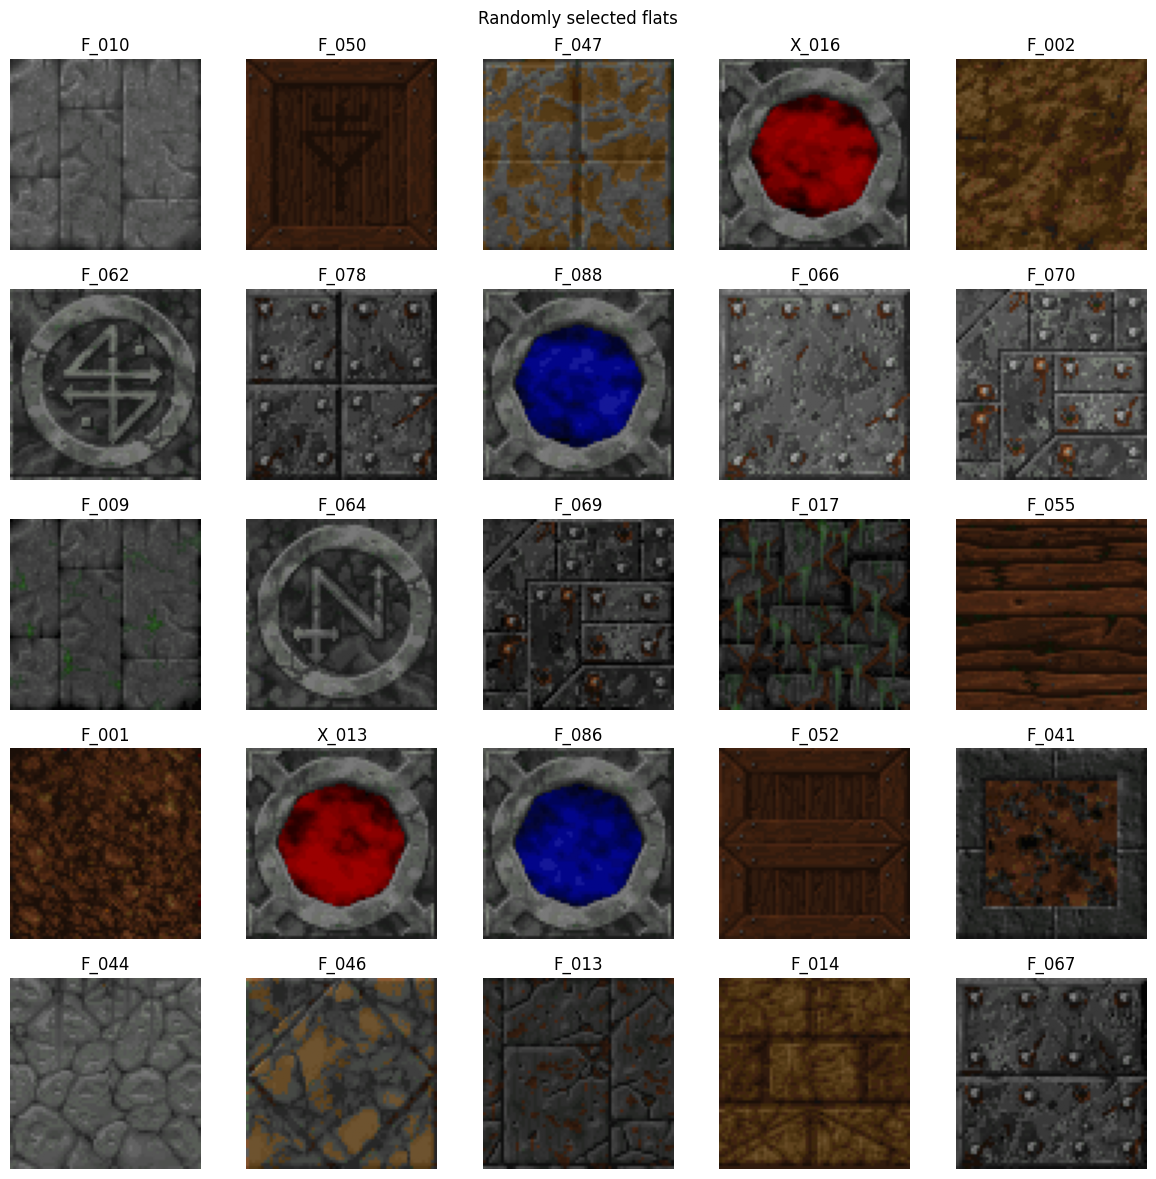

In [32]:
n_flats = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_flat_names = list(w.flats.keys())
selected_flats = np.random.choice(all_flat_names, size=n_flats, replace=False)

for i, flat_name in enumerate(selected_flats):

    rgb_image = w.draw_flat(*w.flats[flat_name])

    ax[i].imshow(rgb_image / 255, aspect='equal')
    ax[i].set_title(flat_name)
    ax[i].axis('off')

fig.suptitle('Randomly selected flats')
fig.tight_layout(pad=1.2)

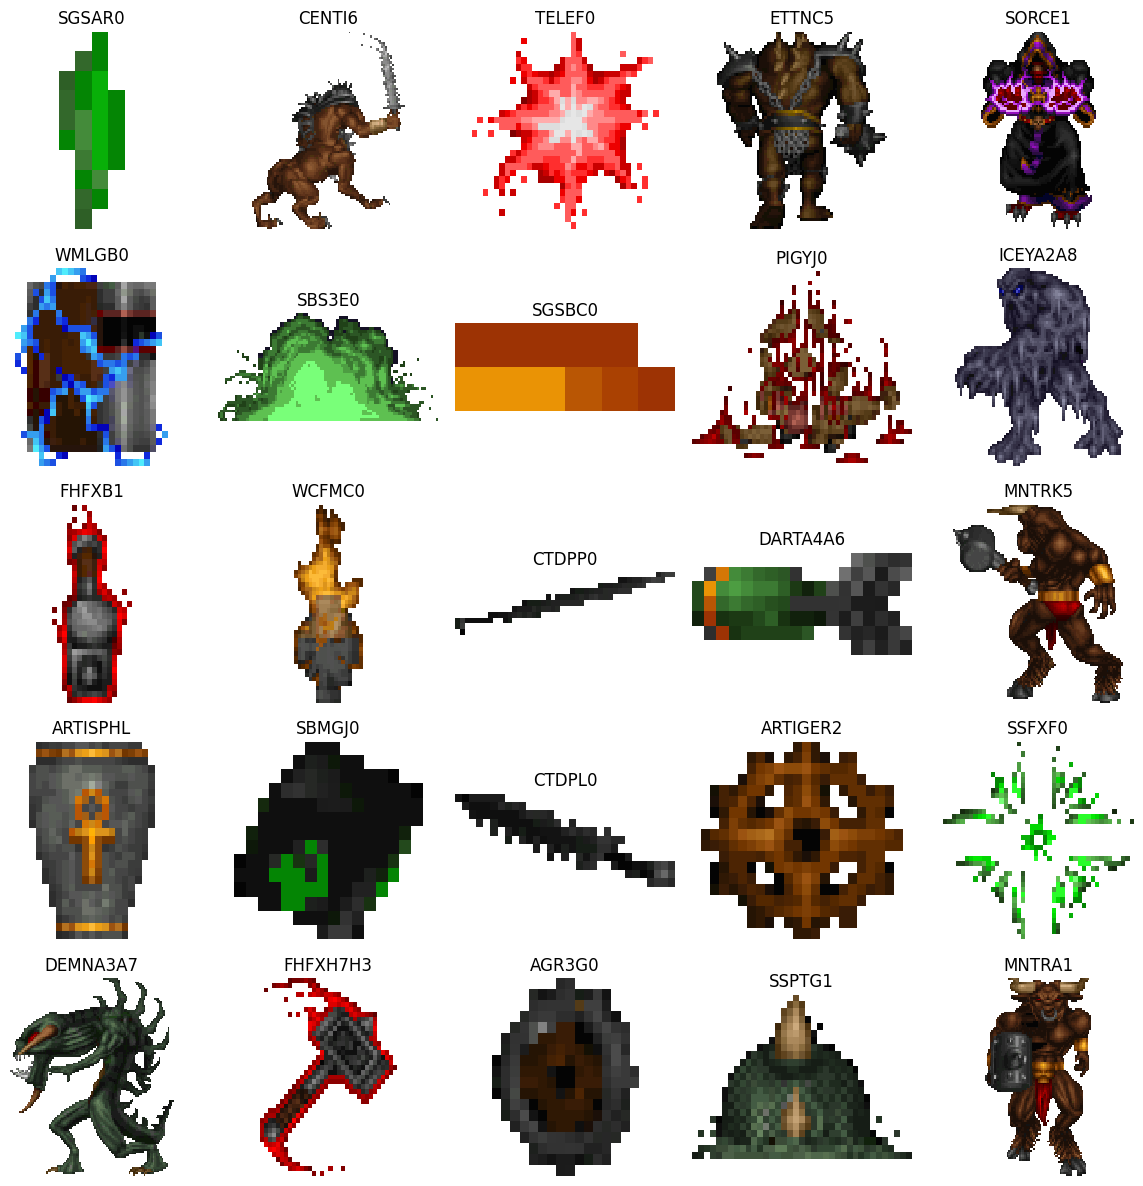

In [33]:
n_sprites = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_sprite_names = list(w.sprites.keys())
selected_sprites = np.random.choice(all_sprite_names, size=n_sprites, replace=False)

for i, sprite_name in enumerate(selected_sprites):

    rgb_image = w.draw_patch(*w.sprites[sprite_name])

    # Original DOOM had non-square pixels!
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest') 
    ax[i].set_title(sprite_name)
    ax[i].axis('off')

fig.tight_layout(pad=1.2)

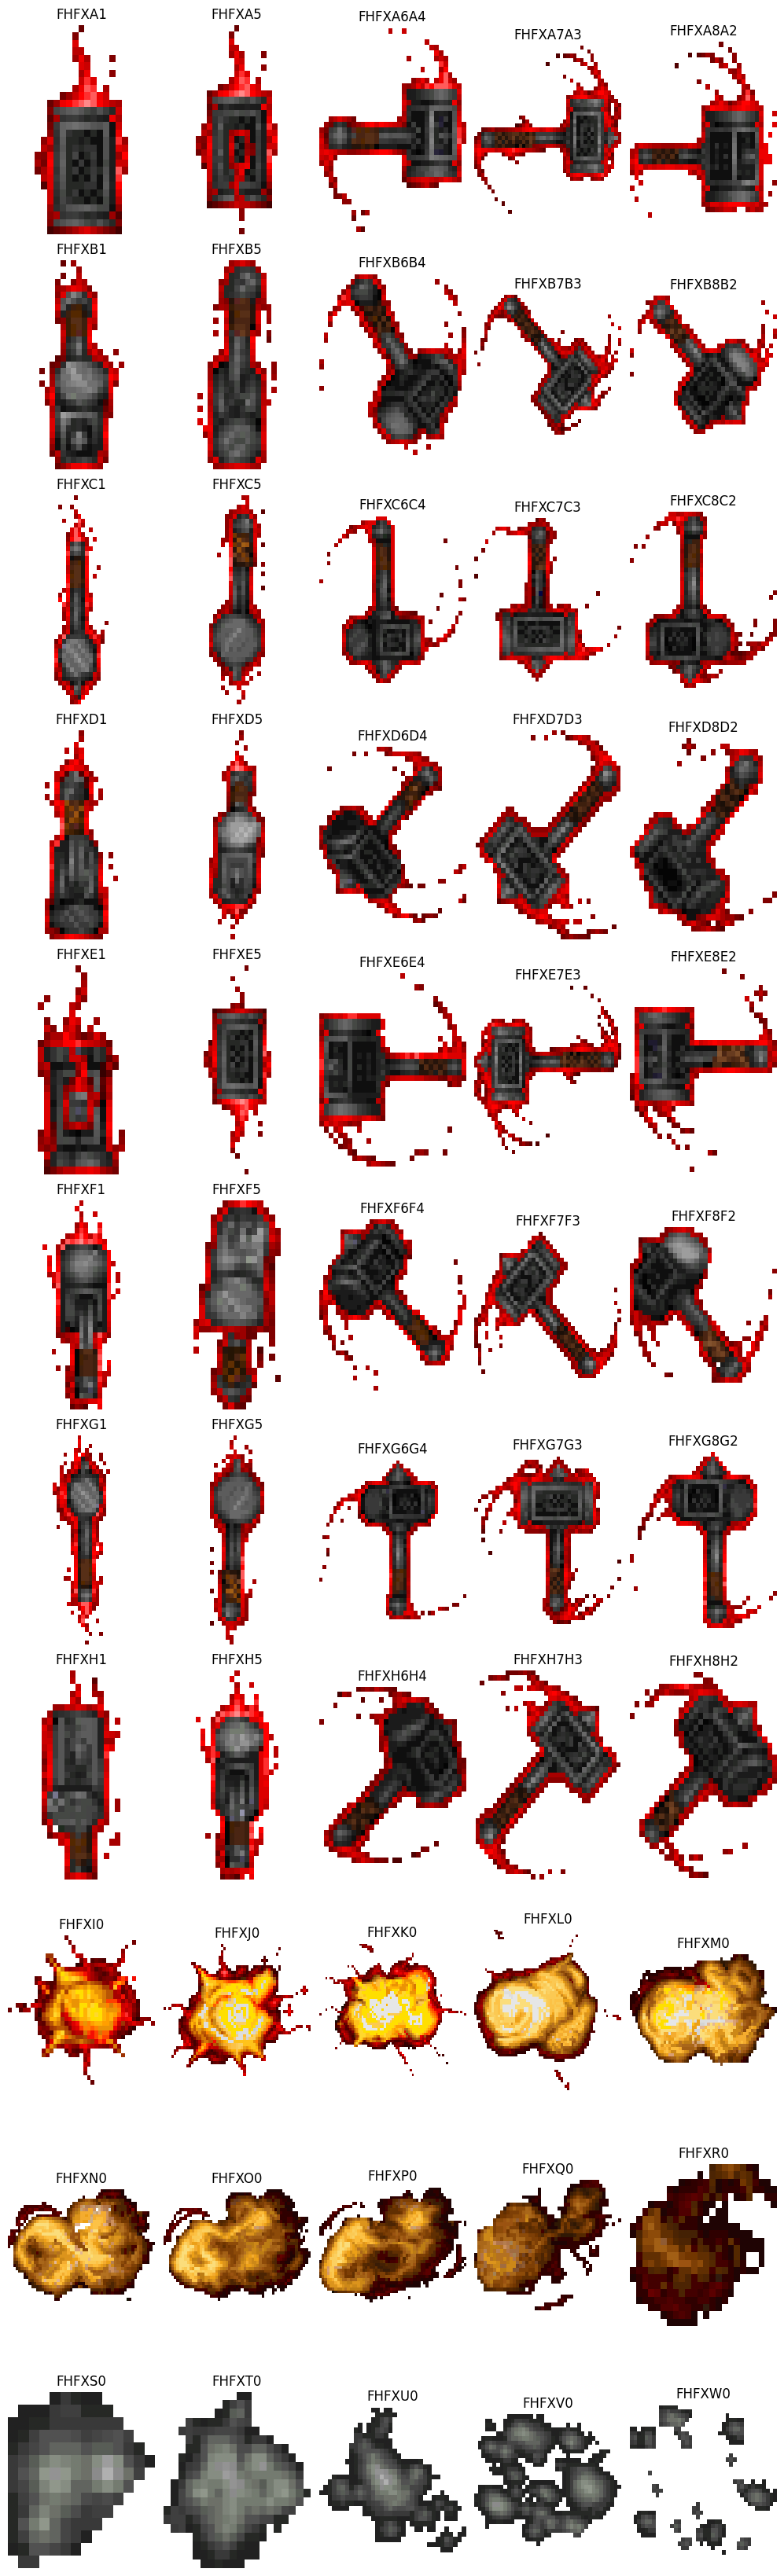

In [37]:
sprite_name = 'FHFX'

sprite_list = w.spritesheets[sprite_name]
ncols=5
nrows = int(np.ceil(len(sprite_list) / ncols))

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*nrows))
ax = ax.ravel()

for i, (name, offset, size) in enumerate(sprite_list):
    
    rgb_image = w.draw_patch(offset, size)
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest')
    ax[i].set_title(name)
    ax[i].axis('off')

[ax[i].set_visible(False) for i in range(len(sprite_list), len(ax))]
fig.tight_layout(pad=0.8)

In [10]:
# Example linedefs array (replace this with your actual data)
linedefs = np.array([[1, 2], [2, 3], [3, 4], [4, 1]])

d = {int(k): int(v) for k, v in zip(linedefs[:, 0], linedefs[:, 1])}
lines = []
idx = 0

while True:
    if len(d) == 0:
        break
    start = next(iter(d))
    line = [start]
    while True:
        next_vertex = d.pop(start, None)
        if next_vertex is None:
            break
        line.append(next_vertex)
        start = next_vertex
    lines.append(line)

print(lines)

[[1, 2, 3, 4, 1]]
